In [21]:
import os
from safetensors import safe_open
import matplotlib.pyplot as plt
import torch

In [15]:
files = os.listdir("/Users/jack/weights/gpt-oss-20b/")
files = [os.path.join("/Users/jack/weights/gpt-oss-20b/", file) for file in files]
files

['/Users/jack/weights/gpt-oss-20b/model-00000-of-00002.safetensors',
 '/Users/jack/weights/gpt-oss-20b/model-00001-of-00002.safetensors',
 '/Users/jack/weights/gpt-oss-20b/model-00002-of-00002.safetensors']

In [22]:
tensors = {}
for file in files:
    with safe_open(file, framework="torch") as f:
        for k in f.keys():
            tensors[k] = f.get_tensor(k)

In [23]:
for k, v in tensors.items():
    print(k, v.shape)


model.layers.0.input_layernorm.weight torch.Size([2880])
model.layers.0.mlp.experts.down_proj_bias torch.Size([32, 2880])
model.layers.0.mlp.experts.down_proj_blocks torch.Size([32, 2880, 90, 16])
model.layers.0.mlp.experts.down_proj_scales torch.Size([32, 2880, 90])
model.layers.0.mlp.experts.gate_up_proj_bias torch.Size([32, 5760])
model.layers.0.mlp.experts.gate_up_proj_blocks torch.Size([32, 5760, 90, 16])
model.layers.0.mlp.experts.gate_up_proj_scales torch.Size([32, 5760, 90])
model.layers.0.mlp.router.bias torch.Size([32])
model.layers.0.mlp.router.weight torch.Size([32, 2880])
model.layers.0.post_attention_layernorm.weight torch.Size([2880])
model.layers.0.self_attn.k_proj.bias torch.Size([512])
model.layers.0.self_attn.k_proj.weight torch.Size([512, 2880])
model.layers.0.self_attn.o_proj.bias torch.Size([2880])
model.layers.0.self_attn.o_proj.weight torch.Size([2880, 4096])
model.layers.0.self_attn.q_proj.bias torch.Size([4096])
model.layers.0.self_attn.q_proj.weight torch.Siz

In [28]:
tensors["model.layers.1.mlp.experts.gate_up_proj_blocks"].shape

torch.Size([32, 5760, 90, 16])

In [30]:
FP4_VALUES = [
    +0.0,
    +0.5,
    +1.0,
    +1.5,
    +2.0,
    +3.0,
    +4.0,
    +6.0,
    -0.0,
    -0.5,
    -1.0,
    -1.5,
    -2.0,
    -3.0,
    -4.0,
    -6.0,
]

In [26]:
def convert_moe_packed_tensors(
    blocks,
    scales,
    *,
    dtype: torch.dtype = torch.bfloat16,
    rows_per_chunk: int = 32768 * 1024,
) -> torch.Tensor:
    """
    TODO this needs to be documented
    """
    import math

    scales = scales.to(torch.int32) - 127

    assert blocks.shape[:-1] == scales.shape, f"{blocks.shape=} does not match {scales.shape=}"

    lut = torch.tensor(FP4_VALUES, dtype=dtype, device=blocks.device)

    *prefix_shape, G, B = blocks.shape
    rows_total = math.prod(prefix_shape) * G

    blocks = blocks.reshape(rows_total, B)
    scales = scales.reshape(rows_total, 1)

    out = torch.empty(rows_total, B * 2, dtype=dtype, device=blocks.device)

    for r0 in range(0, rows_total, rows_per_chunk):
        r1 = min(r0 + rows_per_chunk, rows_total)

        blk = blocks[r0:r1]
        exp = scales[r0:r1]

        # nibble indices -> int64
        idx_lo = (blk & 0x0F).to(torch.long)
        idx_hi = (blk >> 4).to(torch.long)

        sub = out[r0:r1]
        sub[:, 0::2] = lut[idx_lo]
        sub[:, 1::2] = lut[idx_hi]

        torch.ldexp(sub, exp, out=sub)
        del idx_lo, idx_hi, blk, exp

    out = out.reshape(*prefix_shape, G, B * 2).view(*prefix_shape, G * B * 2)
    out = out.to(torch.float8_e5m2).permute(0, 2, 1).contiguous()
    return out

In [34]:
up_layers = []
for k, v in tensors.items():
    if "up_proj_blocks" in k:
        up_layers.append(
            convert_moe_packed_tensors(
                v,
                tensors[k.replace("up_proj_blocks", "up_proj_scales")]
            )[:, :, :5760//2]
        )

In [45]:
up_layers[0].shape

torch.Size([32, 2880, 2880])

In [48]:
layer_stats = []
for layer in up_layers:
    x = layer.to(torch.float32)
    layer_stats.append((
        torch.mean(x, axis=(1, 2)).numpy(),
        torch.std(x, axis=(1, 2)).numpy()
    ))

In [49]:
layer_stats[0]

(array([ 4.3934951e-06,  3.9216029e-06, -2.5894729e-05,  8.3977502e-06,
         7.1537346e-07, -1.3373339e-05, -1.6415914e-05, -4.2599809e-06,
         2.1220314e-05,  3.5920672e-05, -3.4635097e-05, -8.0664367e-06,
         8.7493145e-06,  5.9984936e-06, -6.9239109e-06, -1.8890050e-05,
         3.6858219e-05,  2.0961998e-05,  5.8872315e-06,  7.7056884e-06,
         1.0667495e-05,  2.5073393e-06,  8.8710549e-06, -3.6806414e-05,
         1.6515402e-05,  3.8415648e-05,  4.2313939e-05, -1.0711528e-05,
        -8.0391214e-07,  5.3594140e-06,  1.0419775e-06,  1.8401912e-05],
       dtype=float32),
 array([0.03757619, 0.0430845 , 0.03866874, 0.03813571, 0.03990553,
        0.03340136, 0.03608101, 0.03965282, 0.03780391, 0.0383857 ,
        0.03788155, 0.038621  , 0.03738913, 0.04344557, 0.03778537,
        0.03757034, 0.04112328, 0.04037064, 0.03584595, 0.03890935,
        0.03902031, 0.04059389, 0.0401128 , 0.04973101, 0.03745859,
        0.04456251, 0.04059815, 0.04032237, 0.03994869, 0.03

In [56]:
flat_mean = [(l, stat) for l, layer_stats in enumerate(layer_stats) for e, stat in enumerate(layer_stats[0])]
flat_std = [(l, stat) for l, layer_stats in enumerate(layer_stats) for e, stat in enumerate(layer_stats[1])]

In [57]:
flat_mean

[(0, np.float32(4.393495e-06)),
 (0, np.float32(3.921603e-06)),
 (0, np.float32(-2.589473e-05)),
 (0, np.float32(8.39775e-06)),
 (0, np.float32(7.1537346e-07)),
 (0, np.float32(-1.3373339e-05)),
 (0, np.float32(-1.6415914e-05)),
 (0, np.float32(-4.259981e-06)),
 (0, np.float32(2.1220314e-05)),
 (0, np.float32(3.592067e-05)),
 (0, np.float32(-3.4635097e-05)),
 (0, np.float32(-8.066437e-06)),
 (0, np.float32(8.7493145e-06)),
 (0, np.float32(5.9984936e-06)),
 (0, np.float32(-6.923911e-06)),
 (0, np.float32(-1.889005e-05)),
 (0, np.float32(3.685822e-05)),
 (0, np.float32(2.0961998e-05)),
 (0, np.float32(5.8872315e-06)),
 (0, np.float32(7.705688e-06)),
 (0, np.float32(1.0667495e-05)),
 (0, np.float32(2.5073393e-06)),
 (0, np.float32(8.871055e-06)),
 (0, np.float32(-3.6806414e-05)),
 (0, np.float32(1.6515402e-05)),
 (0, np.float32(3.841565e-05)),
 (0, np.float32(4.231394e-05)),
 (0, np.float32(-1.0711528e-05)),
 (0, np.float32(-8.0391214e-07)),
 (0, np.float32(5.359414e-06)),
 (0, np.float32

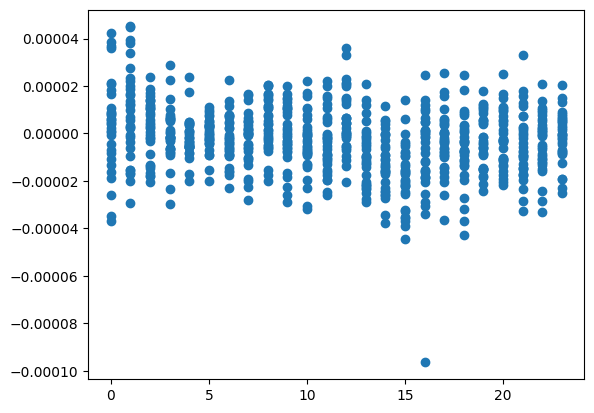

In [ ]:
plt.scatter(x=[x[0] for x in flat_mean], y=[x[1] for x in flat_mean], label="mean")

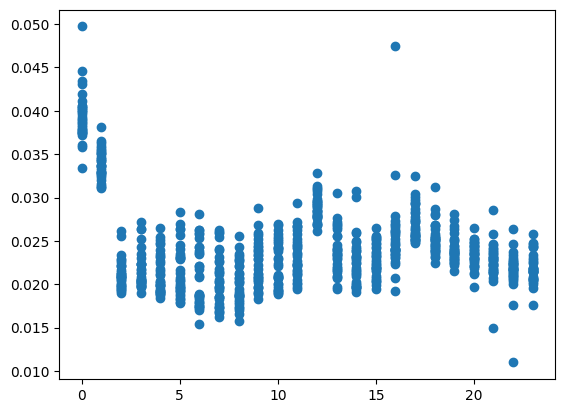

In [59]:
plt.scatter(x=[x[0] for x in flat_std], y=[x[1] for x in flat_std], label="std")